<a href="https://colab.research.google.com/github/nadiasuweer4ya/SkinCancer-ISIC-ClassificationUsing-DenseNet201/blob/main/Skin_Cancer_Comparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00


In [ ]:
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

datasets=("nodoubttome/skin-cancer9-classesisic" "awsaf49/brats20-dataset-training-validation" "competitions/trends-assessment-prediction")

for dataset in "${datasets[@]}"; do
    !kaggle datasets download -d $dataset
done

for dataset in "${datasets[@]}"; do
    unzip "${dataset##*/}.zip"
done

100% 785M/786M [00:35<00:00, 25.1MB/s]
100% 786M/786M [00:35<00:00, 23.0MB/s]
Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Col

In [ ]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
CFG = dict(
        batch_size        =  16,
        epochs            =  20,
        verbose           =   1,
        workers           =   4,

        optimizer         = 'adam',

        RANDOM_STATE      =  123,

        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224,
        img_height        = 224,
        img_width         = 224,

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,
)

In [ ]:
BASEPATH = "/content/skincancer"
df_train_full = pd.read_csv(os.path.join(BASEPATH, 'Train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'Test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

In [ ]:
train_path = '/content/skincancer/Train'
test_path  = '/content/skincancer/Test'

In [ ]:
train_dir = pathlib.Path(train_path)
test_dir  = pathlib.Path(test_path)

In [ ]:
classes=[
    'pigmented benign keratosis',
    'melanoma',
    'vascular lesion',
    'actinic keratosis',
    'squamous cell carcinoma',
    'basal cell carcinoma',
    'seborrheic keratosis',
    'dermatofibroma',
    'nevus'
]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display the first few rows of the dataset
print(df_train_full.head())

# Check the dimensions of the dataset
print("Dimensions of the dataset:", df_train_full.shape)

# Calculate basic statistics for numerical columns
print("Summary statistics for numerical columns:")
print(df_train_full.describe())

# Check for missing values
missing_values = df_train_full.isnull().sum()
print("Missing values in the dataset:")
print(missing_values)

     image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0  
Dimensions of the dataset: (33126, 8)
Summary statistics for numerical columns:
         age_approx        target
count  33058.000000  33126.000000
mean      48.870016      0.017630
std       14.380360      0.131603
min        0.000000      0.000000
25%       40.000000      0.00

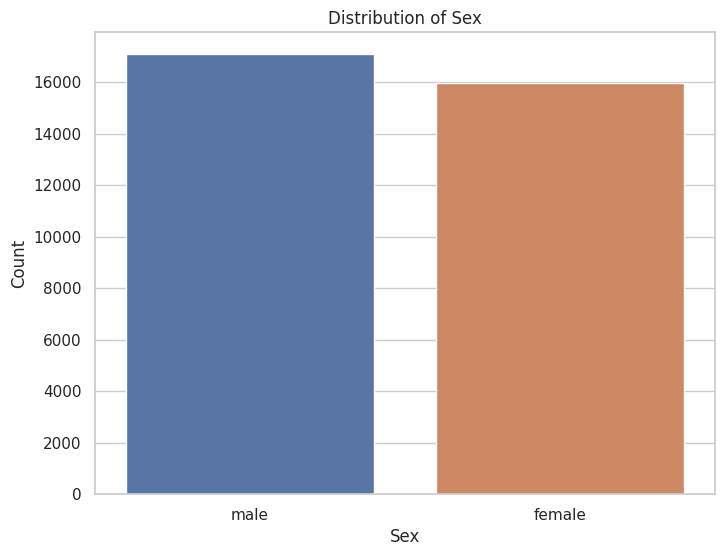

In [ ]:
import seaborn as sns

# Set the style for Seaborn plots
sns.set(style="whitegrid")

# Visualize the distribution of 'sex' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train_full, x='sex', palette='deep')
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

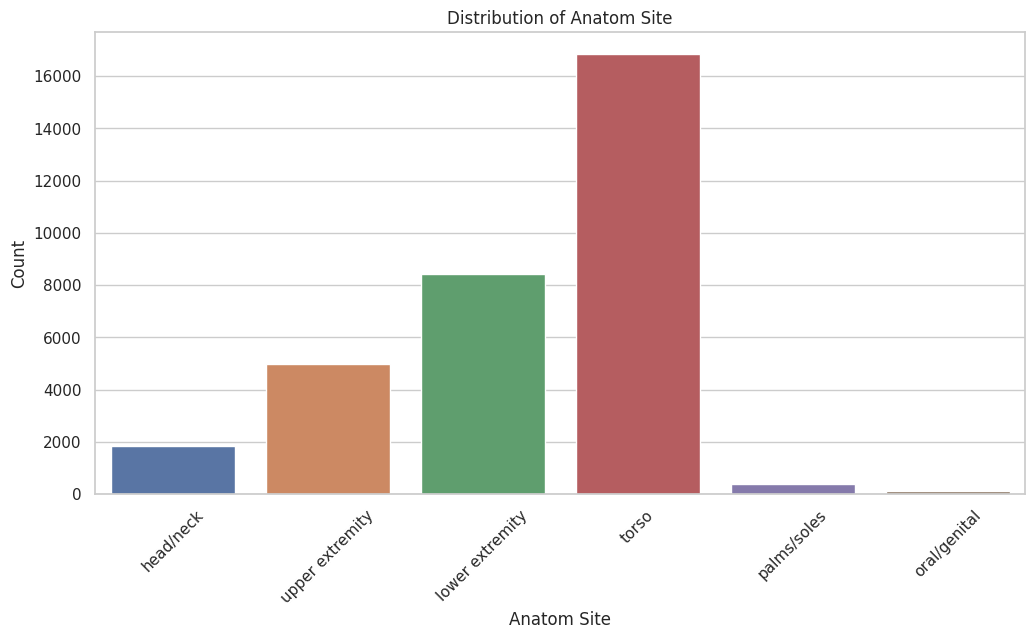

In [ ]:
# Visualize the distribution of 'anatom_site_general_challenge' column
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train_full, x='anatom_site_general_challenge', palette='deep')
plt.title('Distribution of Anatom Site')
plt.xlabel('Anatom Site')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

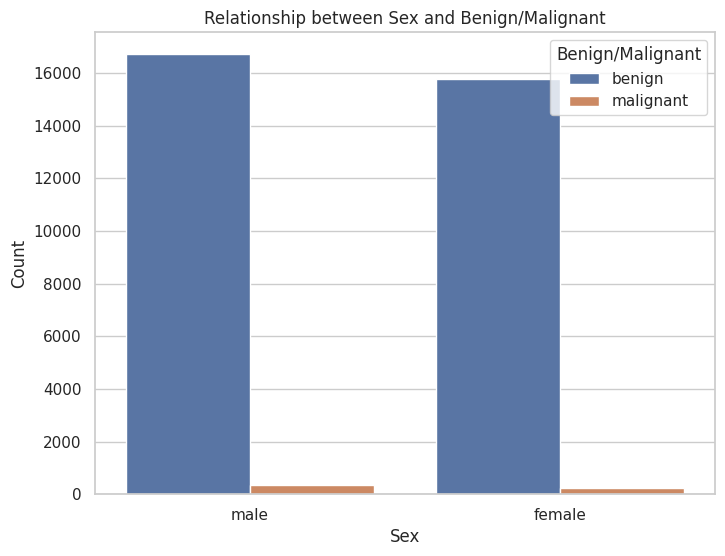

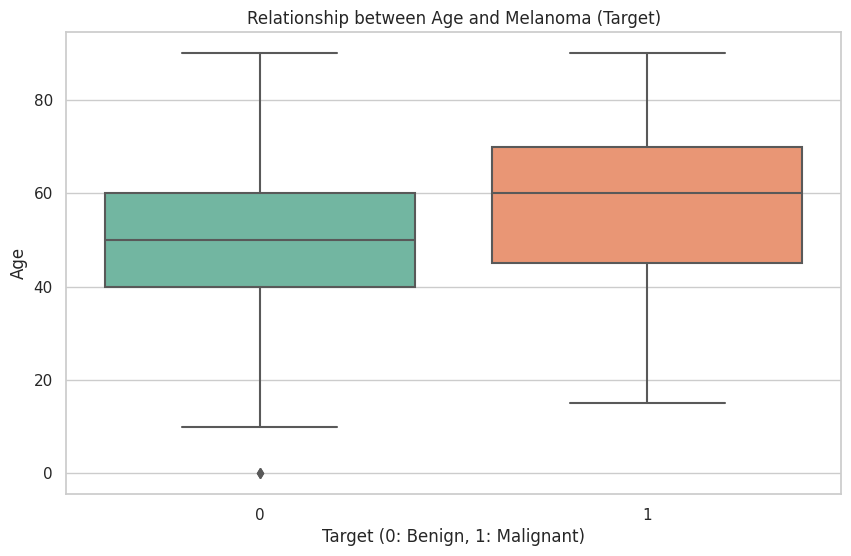

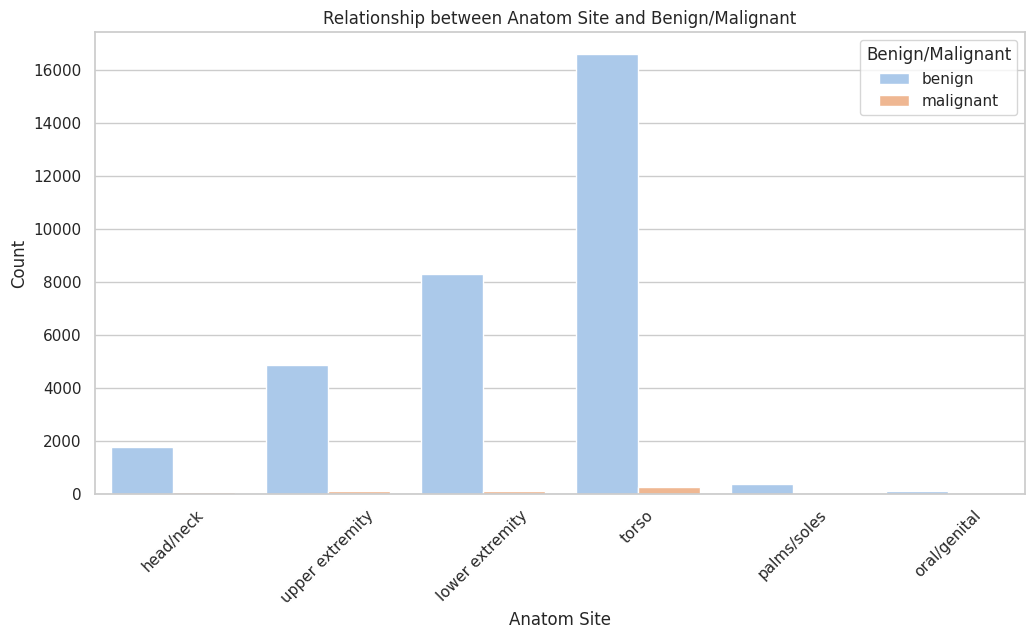

In [ ]:
# Explore the relationship between 'sex' and 'target' (benign or malignant)
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train_full, x='sex', hue='benign_malignant', palette='deep')
plt.title('Relationship between Sex and Benign/Malignant')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Benign/Malignant')
plt.show()

# Explore the relationship between 'age_approx' and 'target'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train_full, x='target', y='age_approx', palette='Set2')
plt.title('Relationship between Age and Melanoma (Target)')
plt.xlabel('Target (0: Benign, 1: Malignant)')
plt.ylabel('Age')
plt.show()

# Explore the relationship between 'anatom_site_general_challenge' and 'target'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train_full, x='anatom_site_general_challenge', hue='benign_malignant', palette='pastel')
plt.title('Relationship between Anatom Site and Benign/Malignant')
plt.xlabel('Anatom Site')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Benign/Malignant')
plt.show()

In [ ]:
# Count number of images in each set.
img_count_train = len(list(train_dir.glob('*/*.jpg')))
img_count_test  = len(list(test_dir.glob('*/*.jpg')))
print('{} train images'.format(img_count_train))
print('{} test  images'.format(img_count_test))

2239 train images
118 test  images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data directory
data_directory = '/content/skincancer'

# Define the ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create the training data generator
train_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 1887 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the data directory
data_directory = '/content/skincancer'

# Create an ImageDataGenerator with data augmentation settings
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2] #
)

# Create a data generator from the directory with augmentation
data_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Load a pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a custom top layer for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the data generator
model.fit(data_generator, epochs=10, steps_per_epoch=len(data_generator))

Found 2357 images belonging to 2 classes.
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/10
74/74 [==============================] - 86s 627ms/step - loss: 0.3312 - accuracy: 0.9440
Epoch 2/10
74/74 [==============================] - 48s 648ms/step - loss: 0.2172 - accuracy: 0.9487
Epoch 3/10
74/74 [==============================] - 47s 634ms/step - loss: 0.2069 - accuracy: 0.9491
Epoch 4/10
74/74 [==============================] - 48s 642ms/step - loss: 0.2098 - accuracy: 0.9499
Epoch 5/10
74/74 [==============================] - 48s 642ms/step - loss: 0.1948 - accuracy: 0.9499
Epoch 6/10
74/74 [==============================] - 47s 640ms/step - loss: 0.2102 - accuracy: 0.9499
Epoch 7/10
74/74 [==============================] - 48s 649ms/step - loss: 0.1974 - accuracy: 0.9499
Epoch 8/10
74/74 [==============================] - 48s 647ms/step - loss: 0.1929 - accuracy: 0.9499
Epoch 9/10
74/74 [==============================] - 48s 645ms/step - loss: 0.1963 - a

In [ ]:
accuracy = model.evaluate(validation_generator)[1]

15/15 [==============================] - 8s 481ms/step - loss: 0.5220 - accuracy: 0.9511


In [ ]:
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.11%


In [ ]:
model_file_path = 'skincancer_nadia.h5'

model.save(model_file_path)

print(f"Model saved to {model_file_path}")

Model saved to skincancer_nadia.h5


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

unique_class_labels = np.unique(train_generator.classes)

class_weights = compute_class_weight(class_weight='balanced', classes=unique_class_labels, y=train_generator.classes)

class_weights_dict = dict(zip(unique_class_labels, class_weights))

print('CLASS WEIGHTS: ', class_weights_dict)

CLASS WEIGHTS:  {0: 9.93157894736842, 1: 0.5265066964285714}


In [ ]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED = 123
np.random.seed(SEED)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation,
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

model = load_model('skincancer_nadia.h5')

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

# Define the directory containing test images
test_image_dir = '/content/skincancer/Test'

# List to store predictions and corresponding image filenames
predictions = []
image_filenames = []

# Iterate through test images
for image_filename in os.listdir(test_image_dir):
    if image_filename.endswith('.jpg'):
        image_path = os.path.join(test_image_dir, image_filename)
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make a prediction
        prediction = model.predict(img)
        predictions.append(prediction[0][0])
        image_filenames.append(image_filename)

if len(predictions) == len(image_filenames):
    # Create a DataFrame for predictions
    df_predictions = pd.DataFrame({
        'image_name': image_filenames,
        'target': predictions
    })

    # Save the predictions to a CSV file
    df_predictions.to_csv('submission.csv', index=False)
else:
    print("Error: Predictions and image filenames have different lengths.")

In [ ]:
import os
from IPython.display import display, Image

image_dir = '/content/skincancer'

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    display(Image(filename=image_path))

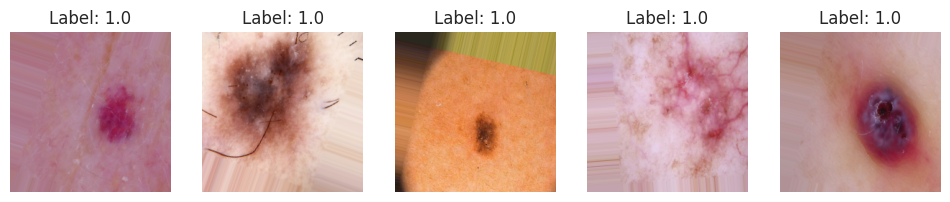

In [ ]:
import matplotlib.pyplot as plt

sample_images, sample_labels = next(train_generator)

def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

plot_images(sample_images, sample_labels, num_images=5)
plt.show()

In [ ]:
!pip install tensorflow
!pip install tensorflow-hub
!pip install tf-slim
!pip install opencv-python

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
input_layer = Input(shape=input_shape)

In [ ]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=input_layer
)

In [ ]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_generator, epochs=10, steps_per_epoch=len(train_generator))

Epoch 1/10
59/59 [==============================] - 62s 591ms/step - loss: 0.4826 - accuracy: 0.9449
Epoch 2/10
59/59 [==============================] - 38s 647ms/step - loss: 0.2160 - accuracy: 0.9497
Epoch 3/10
59/59 [==============================] - 37s 624ms/step - loss: 0.1998 - accuracy: 0.9497
Epoch 4/10
59/59 [==============================] - 38s 637ms/step - loss: 0.1833 - accuracy: 0.9497
Epoch 5/10
59/59 [==============================] - 38s 637ms/step - loss: 0.1935 - accuracy: 0.9497
Epoch 6/10
59/59 [==============================] - 37s 623ms/step - loss: 0.1929 - accuracy: 0.9497
Epoch 7/10
59/59 [==============================] - 37s 635ms/step - loss: 0.1845 - accuracy: 0.9497
Epoch 8/10
59/59 [==============================] - 37s 618ms/step - loss: 0.1873 - accuracy: 0.9497
Epoch 9/10
59/59 [==============================] - 37s 618ms/step - loss: 0.1867 - accuracy: 0.9497
Epoch 10/10
59/59 [==============================] - 37s 627ms/step - loss: 0.1870 - accura

In [ ]:
accuracy = model.evaluate(validation_generator)[1]
print(f'Accuracy: {accuracy * 100:.2f}%')

15/15 [==============================] - 8s 452ms/step - loss: 0.5365 - accuracy: 0.9511
Accuracy: 95.11%


In [ ]:
model.save('skincancer_suweeraya.h5')

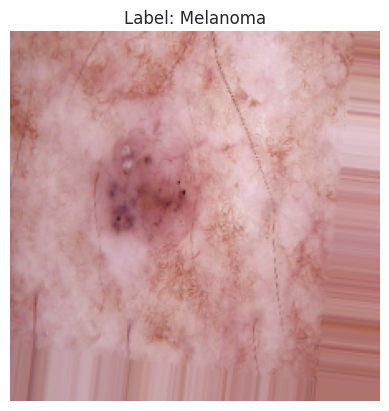

In [ ]:
import matplotlib.pyplot as plt

images, labels = validation_generator.next()

index = 0

image = images[index]
label = labels[index]

label_str = "Melanoma" if label == 1 else "Non-Melanoma"

plt.imshow(image)
plt.title(f"Label: {label_str}")
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 918ms/step


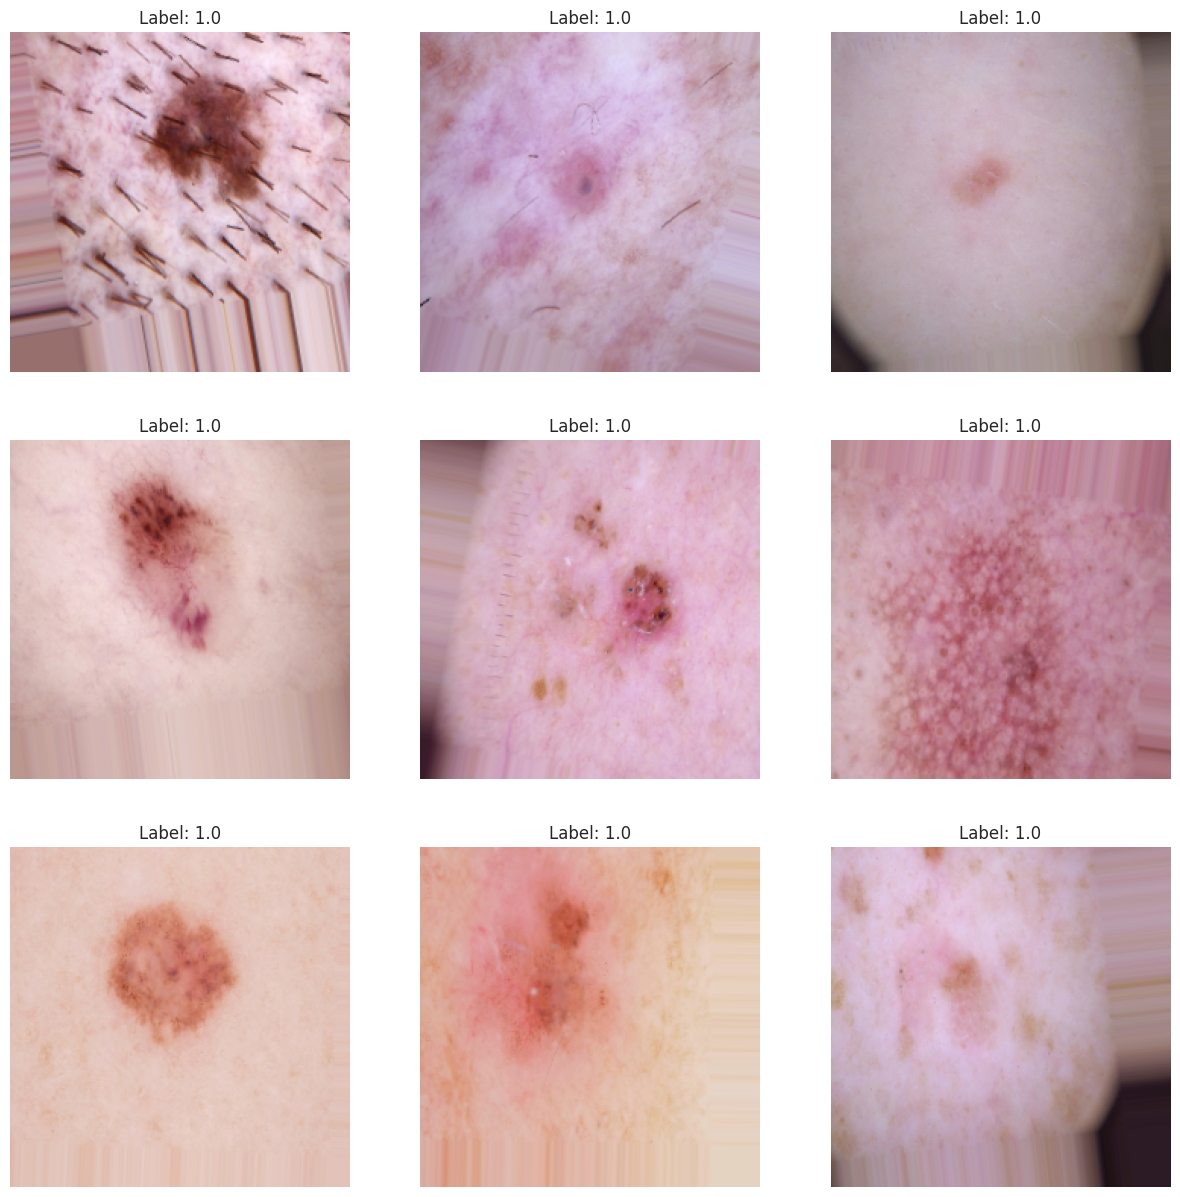

In [ ]:
import matplotlib.pyplot as plt
def plot_images(images, labels, predictions=None):
    plt.figure(figsize=(15, 15))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        if predictions is not None:
            plt.xlabel(f"Predicted: {predictions[i][0]:.2f}")
        plt.axis("off")
    plt.show()
sample_images, sample_labels = validation_generator.next()
predictions = model.predict(sample_images)
plot_images(sample_images, sample_labels, predictions)